In [21]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Method to execute a simulation with given parameters

##### Test the class #####

from __future__ import print_function, division
from fenics import FunctionSpace, Expression, DirichletBC, VectorFunctionSpace
from errorcomputation import compute_errors
from my_enums import DomainPart
from problem_setup import get_geometry
import sympy as sp

from problem_setup import get_geometry
from my_enums import DomainPart

from pySDC.implementations.sweeper_classes.imex_1st_order_mass import imex_1st_order_mass
from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI

from heat_pySDC_problemClass import fenics_heat_2d

import math as math

from pathlib import Path

################################################################
# Definition of fenics stuff
################################################################

# Get the mesh and ignore boundaries as 
# we are only interested in the monolithic case here
domain_mesh, _, remaining_boundary = get_geometry(DomainPart.FULL)

# Define function space using mesh
V = FunctionSpace(domain_mesh, 'P', 2)
V_g = VectorFunctionSpace(domain_mesh, 'P', 1)
W = V_g.sub(0).collapse()

# Create sympy description of manufactured solution
alpha = 3
beta = 1.2
temporal_deg = 10
x_sp, y_sp, t_sp = sp.symbols(['x[0]', 'x[1]', 't'])
u_D_sp = 1 + x_sp * x_sp + alpha * y_sp * y_sp + beta * (t_sp ** temporal_deg)

# Generate fenics expression for manufactured solution and the forcing term
u_D = Expression(sp.ccode(u_D_sp), degree=2, alpha=alpha, beta=beta, temporal_deg=temporal_deg, t=0)
f = Expression(sp.ccode(u_D_sp.diff(t_sp) - u_D_sp.diff(x_sp).diff(x_sp) - u_D_sp.diff(y_sp).diff(y_sp)), degree=2, alpha=alpha, beta=beta, t=0)

remaining_BC = DirichletBC(V, u_D, remaining_boundary)


################################################################
# Routine to setup a problem and run the simulation
# for a certain number of nodes, time step size,
# start and end time
################################################################
def run_simulation(num_nodes, dt, t_start, t_end):
    

    # initialize level parameters
    level_params = dict()
    level_params['restol'] = 1e-12
    level_params['dt'] = dt

    # initialize step parameters
    step_params = dict()
    step_params['maxiter'] = 10

    # initialize sweeper parameters
    sweeper_params = dict()
    sweeper_params['quad_type'] = 'LOBATTO'
    sweeper_params['num_nodes'] = num_nodes

    # initialize problem parameters
    problem_params = dict()
    problem_params['mesh'] = domain_mesh
    problem_params['functionSpace'] = V
    problem_params['couplingBC'] = None
    problem_params['couplingExpr'] = None
    problem_params['remainingBC'] = remaining_BC
    problem_params['solutionExpr'] = u_D
    problem_params['forcingTermExpr'] = f
    problem_params['preciceRef'] = None

    # initialize controller parameters
    controller_params = dict()
    controller_params['logger_level'] = 30

    # fill description dictionary for easy step instantiation
    description = dict()
    description['problem_class'] = fenics_heat_2d
    description['problem_params'] = problem_params
    description['sweeper_class'] = imex_1st_order_mass
    description['sweeper_params'] = sweeper_params
    description['level_params'] = level_params
    description['step_params'] = step_params

    # Controller for time stepping
    controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)

    # Reference to problem class for easy access to exact solution
    P = controller.MS[0].levels[0].prob



    ################################################################
    # Execution of simulation
    ################################################################
    u_init = P.u_exact(t_start)
    u_end, _ = controller.run(u_init, t0=t_start, Tend=t_end)
    u_ref = P.u_exact(t_end)

    # Compute and return the error
    error, _ = compute_errors(u_end.values, u_ref.values, V, 1.0)
    return error

In [24]:
# Specify the number of nodes and time step sizes to test
num_nodes_list = [2 ** i for i in range(1, 5)]
dt_list = [2.0 ** -i for i in range(8)]

# Set start and end time
t_start = 0.0
t_end = 1.0

# Specify if the data should be printed to a file
print_to_file = True

In [25]:
# Run the simulation
###########################################################################################################
# Run simulations with different number of nodes and timesteps to understand convergence
###########################################################################################################
output_data = {}
output_data['dt'] = dt_list

for num_nodes in num_nodes_list:
    print("Run simulation with %d nodes" % num_nodes)
    err_write_curr = []
    err_order_curr = []
    for i, dt in enumerate(dt_list):
        print("|-- Current dt: %.3g" % dt)
        
        error = run_simulation(num_nodes, dt, t_start, t_end)
        err_write_curr.append(error)
        
        if i == 0:
            err_order_curr.append(0)
        else:
            err_order_curr.append(math.log(err_write_curr[i-1] / error, dt_list[i-1] / dt_list[i]))        
        
        print("|   |---- L2 error on domain: %.3g" % error)
        print("|")
    output_data[f"{num_nodes}"] = err_write_curr
    output_data[f"{num_nodes}_order"] = err_order_curr
    print()

# Wrap the collected data in a pandas dataframe
df = pd.DataFrame(output_data)

# Print the data to a file if specified
if print_to_file:
    dir_path = "heat_pySDC_monolithic_output"
    Path(dir_path).mkdir(exist_ok=True, parents=True)
    err_out_name = f"{dir_path}/errors.csv"
    err_out = open(err_out_name, "w")
    df.to_csv(err_out, index=False)



Run simulation with 2 nodes
|-- Current dt: 1
|   |---- L2 error on domain: 0.201
|
|-- Current dt: 0.5
|   |---- L2 error on domain: 0.133
|
|-- Current dt: 0.25
|   |---- L2 error on domain: 0.0557
|
|-- Current dt: 0.125
|   |---- L2 error on domain: 0.0163
|
|-- Current dt: 0.0625
|   |---- L2 error on domain: 0.00424
|
|-- Current dt: 0.0312
|   |---- L2 error on domain: 0.00107
|
|-- Current dt: 0.0156
|   |---- L2 error on domain: 0.000269
|
|-- Current dt: 0.00781
|   |---- L2 error on domain: 6.72e-05
|

Run simulation with 4 nodes
|-- Current dt: 1
|   |---- L2 error on domain: 0.0504
|
|-- Current dt: 0.5
|   |---- L2 error on domain: 0.00602
|
|-- Current dt: 0.25
|   |---- L2 error on domain: 0.000277
|
|-- Current dt: 0.125
|   |---- L2 error on domain: 8.71e-06
|
|-- Current dt: 0.0625
|   |---- L2 error on domain: 2.63e-07
|
|-- Current dt: 0.0312
|   |---- L2 error on domain: 7.42e-09
|
|-- Current dt: 0.0156
|   |---- L2 error on domain: 1.95e-10
|
|-- Current dt: 0.0

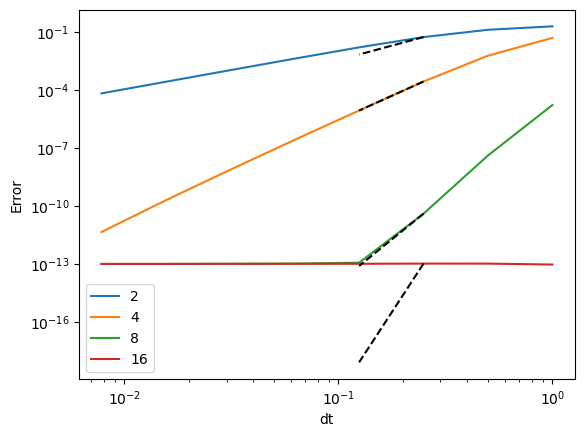

In [30]:
load_from_file = False
if load_from_file:
    df = pd.read_csv('errors.csv')

fig, ax = plt.subplots()

df.plot(x='dt', y=[f"{num_nodes}" for num_nodes in num_nodes_list], ax=ax)

ax.set_xlabel('dt')
ax.set_ylabel('Error')
ax.set_xscale('log', base=2)
ax.set_yscale('log', base=10)


# Plot order guides into the plot

# Set expected orders for guides
# The expected order is the number of nodes + 1
expected_orders = [num_nodes + 1 for num_nodes in num_nodes_list]

for i, num_nodes in enumerate(num_nodes_list):
    dt_list_adjusted = dt_list[2:4]
    order = expected_orders[i]
    base_error = df[f"{num_nodes}"][2]
    order_guide = [base_error / (2 ** (order*i)) for i in range(0, len(dt_list_adjusted))]
    ax.loglog(dt_list_adjusted, order_guide, color='black', linestyle='dashed', label=f"Order {order}")